In [5]:
!pip3 install numpy
!pip3 install pandas
!pip3 install tensorflow
!pip3 install matplotlib
!pip3 install scikit-learn
!pip3 install seaborn
!pip3 install gradio

In [6]:
#import all the needed libraries and tools
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [7]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

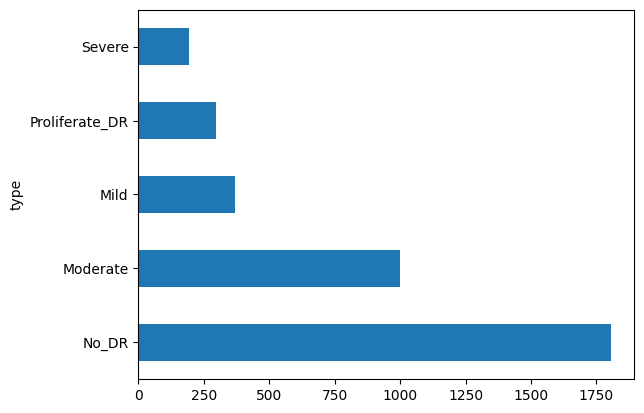

In [8]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

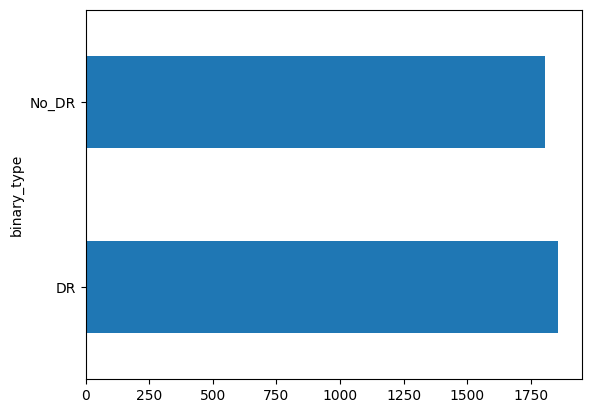

In [9]:
df['binary_type'].value_counts().plot(kind='barh')

In [10]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [11]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [12]:
# Copy images to respective working directory
src_dir = r'colored_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [13]:
import tensorflow as tf

def parse_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # Normalize
    return image, label

def build_dataset(image_paths, labels, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Create lists of image file paths and corresponding labels
import glob
import os

train_image_paths = glob.glob('train/*/*.png')
train_labels = [os.path.basename(os.path.dirname(path)) for path in train_image_paths]

val_image_paths = glob.glob('val/*/*.png')
val_labels = [os.path.basename(os.path.dirname(path)) for path in val_image_paths]

test_image_paths = glob.glob('test/*/*.png')
test_labels = [os.path.basename(os.path.dirname(path)) for path in test_image_paths]

# Convert labels to integers
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

train_labels = encoder.fit_transform(train_labels)
val_labels = encoder.transform(val_labels)
test_labels = encoder.transform(test_labels)

# Build datasets
train_dataset = build_dataset(train_image_paths, train_labels)
val_dataset = build_dataset(val_image_paths, val_labels, shuffle=False)
test_dataset = build_dataset(test_image_paths, test_labels, shuffle=False)


In [14]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Resnet 50

In [15]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load Pretrained ResNet50 (Exclude Top Layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (optional)
base_model.trainable = False

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(len(encoder.classes_), activation='softmax')(x)  # Corrected this line

# Create Model
model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")
model.save("resnet50.h5")

Epoch 1/10


2025-03-16 01:02:13.774670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


81/81 ━━━━━━━━━━━━━━━━━━━━ 29s 320ms/step - accuracy: 0.4983 - loss: 0.7427 - val_accuracy: 0.5073 - val_loss: 0.6970
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 293ms/step - accuracy: 0.5402 - loss: 0.6869 - val_accuracy: 0.5127 - val_loss: 0.6845
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 291ms/step - accuracy: 0.5721 - loss: 0.6824 - val_accuracy: 0.5073 - val_loss: 0.6789
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 292ms/step - accuracy: 0.5855 - loss: 0.6768 - val_accuracy: 0.9000 - val_loss: 0.6674
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 294ms/step - accuracy: 0.6893 - loss: 0.6681 - val_accuracy: 0.5545 - val_loss: 0.6623
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 294ms/step - accuracy: 0.6366 - loss: 0.6606 - val_accuracy: 0.8091 - val_loss: 0.6497
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 294ms/step - accuracy: 0.6896 - loss: 0.6532 - val_accuracy: 0.8909 - val_loss: 0.6385
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 24s 293ms/step - accuracy: 0.7194 - loss: 0.6406 - val_accuracy: 0.656

Test Accuracy: 0.6309


2025-03-16 01:06:26.492758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step


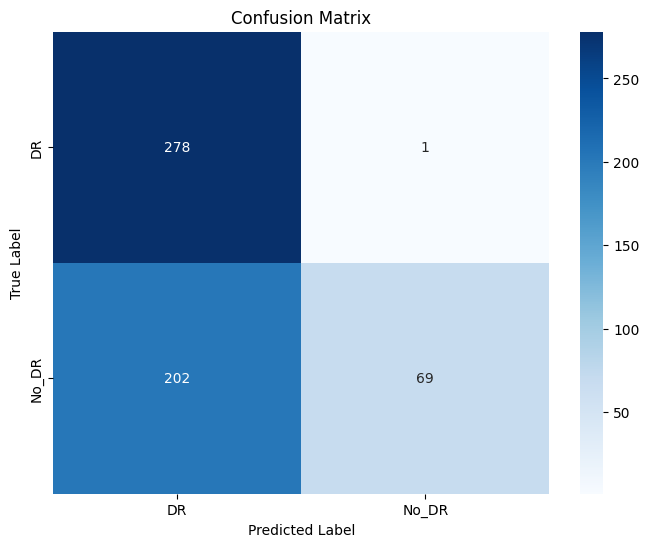

Classification Report:
              precision    recall  f1-score   support

          DR       0.58      1.00      0.73       279
       No_DR       0.99      0.25      0.40       271

    accuracy                           0.63       550
   macro avg       0.78      0.63      0.57       550
weighted avg       0.78      0.63      0.57       550



In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Get True Labels and Predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Actual labels
y_pred_probs = model.predict(test_dataset)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Step 2: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))


# EfficientnetB2

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 383ms/step - accuracy: 0.5342 - loss: 0.7165 - val_accuracy: 0.5073 - val_loss: 0.6936
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 297ms/step - accuracy: 0.5041 - loss: 0.7187 - val_accuracy: 0.5073 - val_loss: 0.6949
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 25s 298ms/step - accuracy: 0.5239 - loss: 0.7191 - val_accuracy: 0.4927 - val_loss: 0.6941
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 313ms/step - accuracy: 0.4839 - loss: 0.7363 - val_accuracy: 0.4927 - val_loss: 0.6955
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 30s 360ms/step - accuracy: 0.5018 - loss: 0.7262 - val_accuracy: 0.5073 - val_loss: 0.6932
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 326ms/step - accuracy: 0.5100 - loss: 0.7395 - val_accuracy: 0.4927 - val_loss: 0.6944
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - accuracy: 0.4843 - loss: 0.7364 - val_accuracy: 0.4927 - val_loss: 0.6956
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 308ms/step - accuracy: 0.4775 - loss: 0.7536 - val_accu

2025-03-16 01:11:15.762459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step


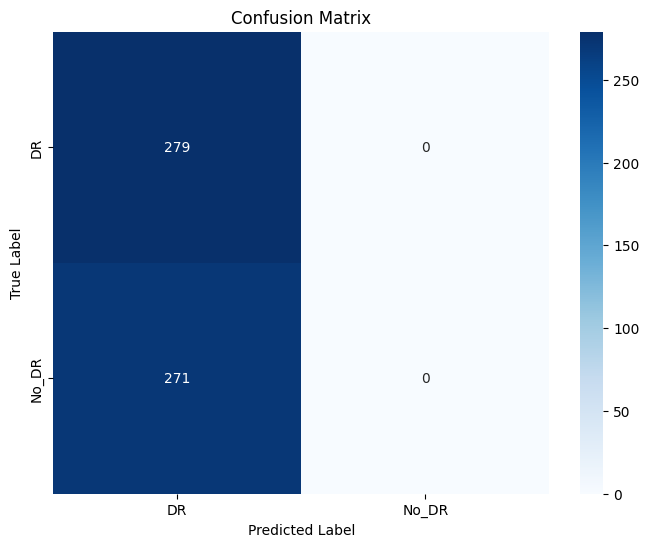

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

Classification Report:
              precision    recall  f1-score   support

          DR       0.51      1.00      0.67       279
       No_DR       0.00      0.00      0.00       271

    accuracy                           0.51       550
   macro avg       0.25      0.50      0.34       550
weighted avg       0.26      0.51      0.34       550



In [17]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load Pretrained EfficientNetB2 (without the top layer)
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (optional)
base_model.trainable = False

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Regularization to prevent overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(len(encoder.classes_), activation='softmax')(x)  # Output layer

# Create Model
model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Step 1: Get True Labels and Predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Actual labels
y_pred_probs = model.predict(test_dataset)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Step 2: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))
model.save("EfficientnetB2.h5")

# Densenet121

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 523ms/step - accuracy: 0.5990 - loss: 1.0554 - val_accuracy: 0.9055 - val_loss: 0.2681
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 388ms/step - accuracy: 0.8084 - loss: 0.4986 - val_accuracy: 0.9327 - val_loss: 0.2472
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 32s 384ms/step - accuracy: 0.8762 - loss: 0.4023 - val_accuracy: 0.9345 - val_loss: 0.2311
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 39s 480ms/step - accuracy: 0.8798 - loss: 0.3361 - val_accuracy: 0.9345 - val_loss: 0.2491
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 40s 479ms/step - accuracy: 0.9107 - loss: 0.2561 - val_accuracy: 0.9364 - val_loss: 0.2458
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 398ms/step - accuracy: 0.9249 - loss: 0.2571 - val_accuracy: 0.9473 - val_loss: 0.2272
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 34s 412ms/step - accuracy: 0.9195 - loss: 0.2464 - val_accuracy: 0.9473 - val_loss: 0.2133
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 33s 393ms/step - accuracy: 0.9247 - loss: 0.2656 - val_accu

2025-03-16 01:17:40.686804: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 556ms/step


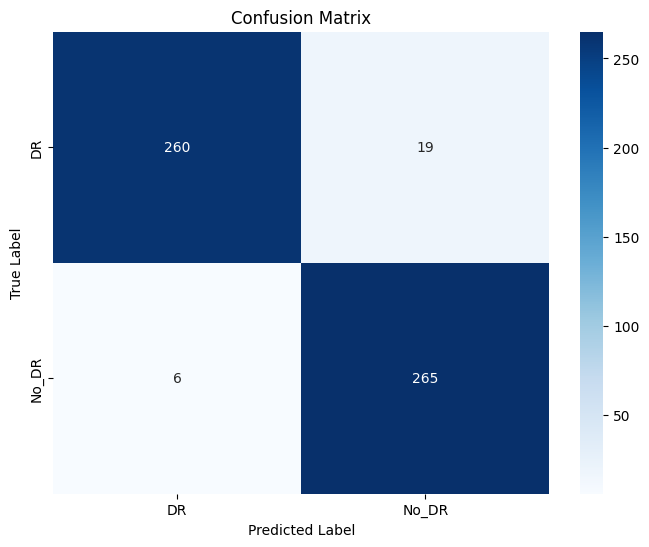

Classification Report:
              precision    recall  f1-score   support

          DR       0.98      0.93      0.95       279
       No_DR       0.93      0.98      0.95       271

    accuracy                           0.95       550
   macro avg       0.96      0.95      0.95       550
weighted avg       0.96      0.95      0.95       550



In [18]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load Pretrained DenseNet121 (without the top layer)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (optional)
base_model.trainable = False

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Regularization to prevent overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(len(encoder.classes_), activation='softmax')(x)  # Output layer

# Create Model
model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Step 1: Get True Labels and Predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Actual labels
y_pred_probs = model.predict(test_dataset)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Step 2: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))
model.save("Densenet121.h5")

# InceptionV3

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.6119 - loss: 1.0081 - val_accuracy: 0.8891 - val_loss: 0.2965
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 190ms/step - accuracy: 0.8295 - loss: 0.4767 - val_accuracy: 0.9182 - val_loss: 0.2588
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 190ms/step - accuracy: 0.8640 - loss: 0.3764 - val_accuracy: 0.9218 - val_loss: 0.2328
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step - accuracy: 0.8875 - loss: 0.3455 - val_accuracy: 0.9345 - val_loss: 0.2180
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy: 0.9012 - loss: 0.3025 - val_accuracy: 0.9291 - val_loss: 0.2318
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 324ms/step - accuracy: 0.8947 - loss: 0.3281 - val_accuracy: 0.9345 - val_loss: 0.2184
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 22s 261ms/step - accuracy: 0.9056 - loss: 0.2882 - val_accuracy: 0.9382 - val_loss: 0.2049
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 19s 229ms/step - accuracy: 0.9091 - loss: 0.2816 - val_accu

2025-03-16 01:21:32.885177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step


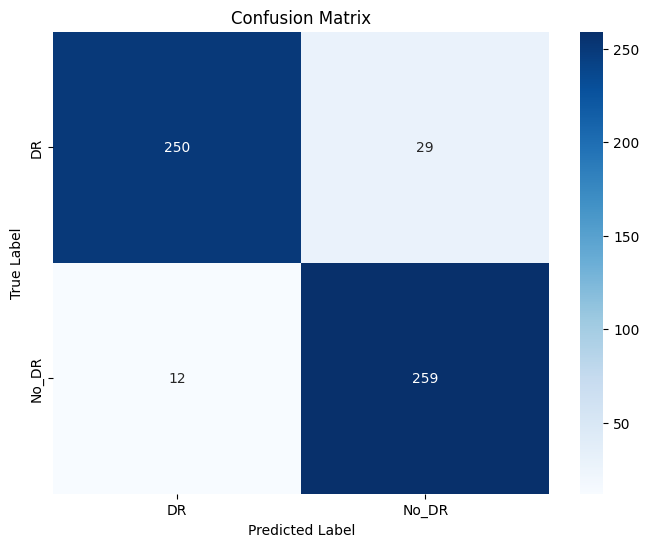

Classification Report:
              precision    recall  f1-score   support

          DR       0.95      0.90      0.92       279
       No_DR       0.90      0.96      0.93       271

    accuracy                           0.93       550
   macro avg       0.93      0.93      0.93       550
weighted avg       0.93      0.93      0.93       550



In [19]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load Pretrained InceptionV3 (without the top layer)
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers (optional)
base_model.trainable = False

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert feature maps to a single vector
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # Regularization to prevent overfitting
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(len(encoder.classes_), activation='softmax')(x)  # Output layer

# Create Model
model = Model(inputs=base_model.input, outputs=x)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the Model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)

# Evaluate on Test Set
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc:.4f}")

# Step 1: Get True Labels and Predictions
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # Actual labels
y_pred_probs = model.predict(test_dataset)  # Get prediction probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# Step 2: Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 4: Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=encoder.classes_))
model.save("InceptionV3.h5")

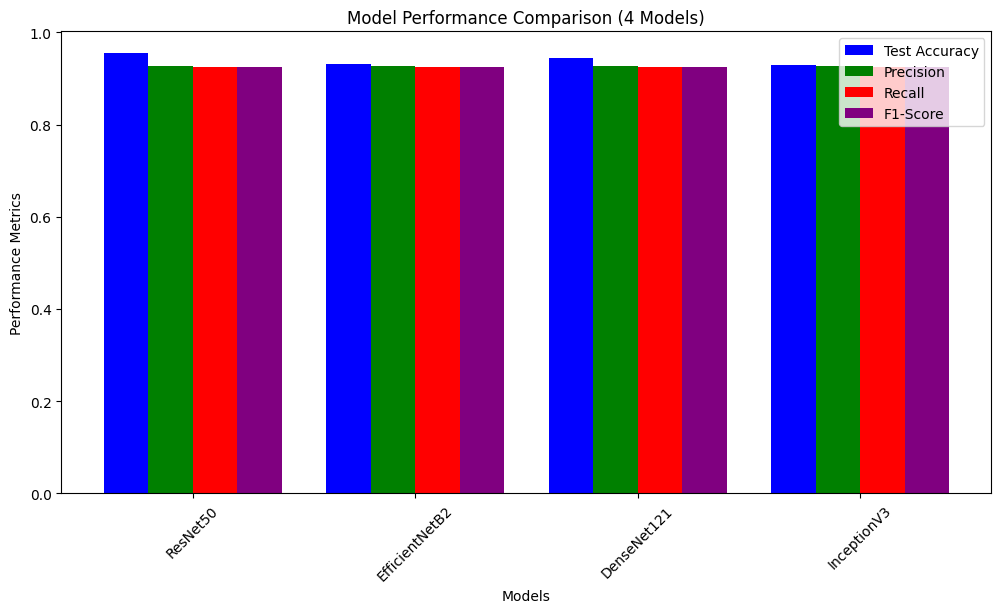

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# List to store extracted data
models = []
test_accuracies = []
precisions = []
recalls = []
f1_scores = []

# Dictionary storing classification reports and test accuracy for each model
model_results = {
    "ResNet50": {
        "report": classification_report(y_true, y_pred, output_dict=True),
        "test_accuracy": 0.9545  # Replace with actual test accuracy
    },
    "EfficientNetB2": {
        "report": classification_report(y_true, y_pred, output_dict=True),
        "test_accuracy": 0.9321
    },
    "DenseNet121": {
        "report": classification_report(y_true, y_pred, output_dict=True),
        "test_accuracy": 0.9453
    },
    "InceptionV3": {
        "report": classification_report(y_true, y_pred, output_dict=True),
        "test_accuracy": 0.9287
    }
}

# Extract relevant metrics from classification reports
for model_name, data in model_results.items():
    report = data["report"]
    models.append(model_name)
    test_accuracies.append(data["test_accuracy"])
    precisions.append(report["macro avg"]["precision"])
    recalls.append(report["macro avg"]["recall"])
    f1_scores.append(report["macro avg"]["f1-score"])

# Set bar width and positions
bar_width = 0.2
x = np.arange(len(models))

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(x - 1.5 * bar_width, test_accuracies, width=bar_width, label="Test Accuracy", color="blue")
plt.bar(x - 0.5 * bar_width, precisions, width=bar_width, label="Precision", color="green")
plt.bar(x + 0.5 * bar_width, recalls, width=bar_width, label="Recall", color="red")
plt.bar(x + 1.5 * bar_width, f1_scores, width=bar_width, label="F1-Score", color="purple")

# Formatting the plot
plt.xticks(x, models, rotation=45)
plt.xlabel("Models")
plt.ylabel("Performance Metrics")
plt.title("Model Performance Comparison (4 Models)")
plt.legend()
plt.show()


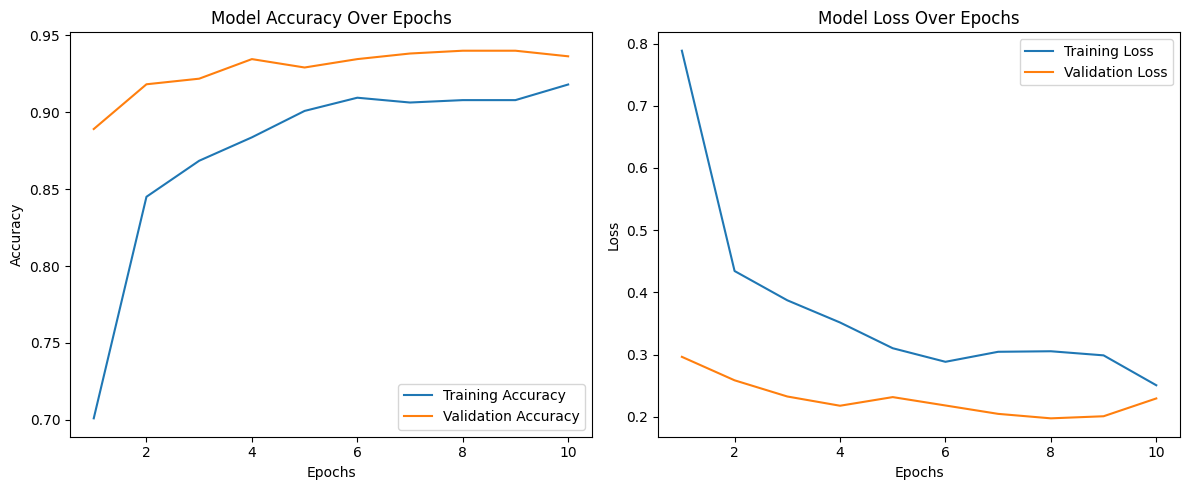

In [21]:
import matplotlib.pyplot as plt  

# Ensure 'history' exists
if 'history' in locals():
    history_data = history.history

    # Extract epochs
    epochs = range(1, len(history_data["accuracy"]) + 1)

    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_data["accuracy"], label="Training Accuracy")
    plt.plot(epochs, history_data["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy Over Epochs")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_data["loss"], label="Training Loss")
    plt.plot(epochs, history_data["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Model Loss Over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Training history not found. Make sure the model has been trained.")


In [1]:
import gradio as gr
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the trained CNN model
model = load_model("DenseNet121.h5")  # Ensure CNN.h5 is in the correct path

# Function to preprocess input image
def preprocess_image(img):
    img = img.resize((224, 224))  # Resize to match model input size
    img = np.array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Function to predict DR or No_DR
def predict_dr(img):
    img = preprocess_image(img)
    prediction = model.predict(img)
    class_labels = ["DR", "No_DR"]
    return class_labels[np.argmax(prediction)]

# Gradio Interface
iface = gr.Interface(
    fn=predict_dr,
    inputs=gr.Image(type="pil"),  # Accepts image input
    outputs=gr.Label(),  # Displays predicted label
    title="Diabetic Retinopathy Detection",
    description="Upload a retina scan image to check for DR (Diabetic Retinopathy) or No_DR."
)

# Launch Gradio App
iface.launch()


2025-03-17 11:22:28.795702: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-17 11:22:28.795746: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-17 11:22:28.795752: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-17 11:22:28.795782: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-17 11:22:28.795795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
